In [1]:
# Importing the necessary libraries
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data

### Importing Raw Data`

In [3]:
db_host = '18.136.56.185'
username = 'dm_team2'
user_pass = 'dm_team1118#'
db_name = 'project_sales'

conn = create_engine('mysql+pymysql://'+username+':'+user_pass+'@'+db_host+'/'+db_name)
conn.table_names()

['data']

In [4]:
query = 'select * from data'

In [5]:
# Importing raw data through SQL Server
data = pd.read_sql(query,conn)

## Source Code

### Exploratory Data Analysis

In [6]:
data.shape

(7422, 9)

In [7]:
data.head()

,Created,Product_ID,Source,Mobile,EMAIL,Sales_Agent,Location,Delivery_Mode,Status
0,14-11-2018 10:05,,Website,984XXXXXXX,aXXXXXXX@gmail.com,Sales-Agent-11,,Mode-5,Open
1,14-11-2018 09:22,,Website,XXXXXXX,#VALUE!,Sales-Agent-10,,Mode-5,Open
2,14-11-2018 09:21,,Website,XXXXXXX,dXXXXXXX@yahoo.com,Sales-Agent-10,,Mode-5,Open
3,14-11-2018 08:46,,Website,XXXXXXX,wXXXXXXX@gmail.com,Sales-Agent-10,,Mode-5,Open
4,14-11-2018 07:34,,Website,XXXXXXX,cXXXXXXX@gmail.com,Sales-Agent-10,,Mode-5,Open


In [8]:
# Dropping the columns which are of no use in analysis
data.drop(['Mobile'],axis=1,inplace=True)
data.drop(['EMAIL'],axis=1,inplace=True)
data.drop(['Created'],axis=1,inplace=True)

In [9]:
# Dropping rows with missing data because they are few
data.replace('',np.nan,inplace=True)
data.dropna(inplace=True)
data.reset_index(inplace=True,drop=True)
data.shape

(7328, 6)

In [10]:
# Compressing and Merging the labes in column
data.Source.replace(['Live Chat-Direct','Live Chat-Google Organic','Live Chat -PPC','Live Chat-Blog','Live Chat-Quora',
                    'Live Chat-CPC','Live Chat-Google Ads','Live Chat-Adwords Remarketing','Live Chat-Youtube',
                    'Live Chat-Justdial'],'Live Chat',inplace=True)
data.Source.replace(['Existing Client','CRM form','Personal Contact'],'Existing Customer',inplace=True)
data.Source.replace('By Recommendation','Customer Referral',inplace=True)
data.Source.replace(['US Website','Just Dial'],'Website',inplace=True)
data.Source.replace(['E-mail Campaign','SMS Campaign','E-Mail Message','Other'],'Campaign',inplace=True)

In [11]:
data.Location.replace(['UAE','USA','UK','AUSTRALIA','Singapore','Malaysia','EUROPE'],'Foreign',inplace=True)
data.Location.replace(['Howrah','Kolkata','Trivandrum'],'Other Locations',inplace=True)

In [12]:
data.Product_ID.replace(['8','6','3','17','22','11','7','28','0','23','24','16','13','4','14','26','12','2','21','25'],
                        'Less Sold Product',inplace=True)

In [13]:
# Defining 'Status' as 'Good' or 'Bad'
data.Status.replace(['CONVERTED','converted','In Progress Positive','Potential','Long Term','Open'],'Good',inplace=True)
data.Status.replace(['LOST','In Progress Negative','Not Responding','Junk Lead','Just Enquiry'],'Bad',inplace=True)

In [14]:
data.head()

,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status
0,9,Live Chat,Sales-Agent-3,Bangalore,Mode-1,Good
1,19,Call,Sales-Agent-4,Other Locations,Mode-5,Good
2,18,Website,Sales-Agent-11,Other Locations,Mode-1,Good
3,15,Website,Sales-Agent-7,Hyderabad,Mode-1,Bad
4,18,Call,Sales-Agent-7,Bangalore,Mode-1,Good


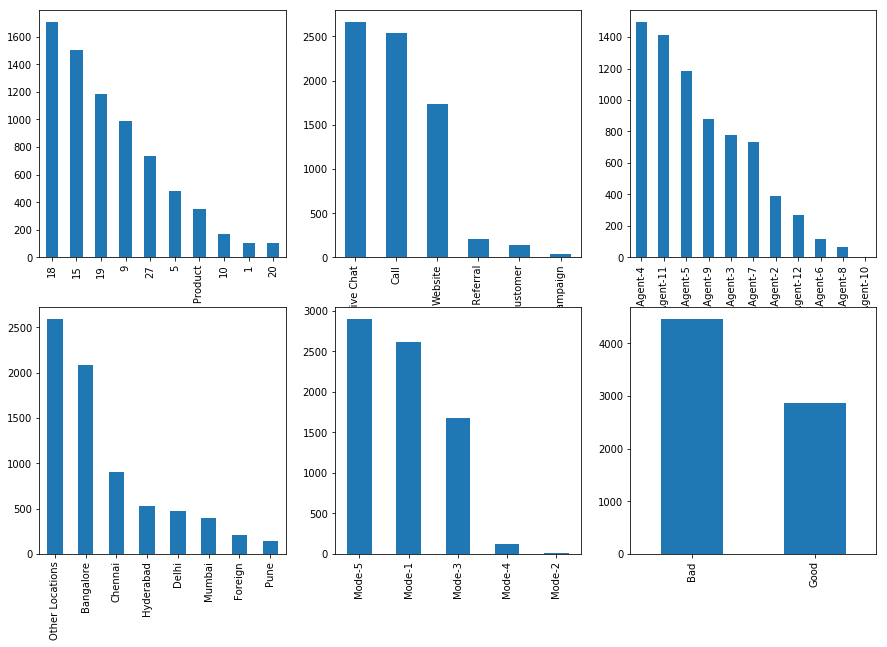

In [15]:
# Plotting the labels in each column
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
data.Product_ID.value_counts().plot(kind='bar')
plt.subplot(2,3,2)
data.Source.value_counts().plot(kind='bar')
plt.subplot(2,3,3)
data.Sales_Agent.value_counts().plot(kind='bar')
plt.subplot(2,3,4)
data.Location.value_counts().plot(kind='bar')
plt.subplot(2,3,5)
data.Delivery_Mode.value_counts().plot(kind='bar')
plt.subplot(2,3,6)
data.Status.value_counts().plot(kind='bar')

### Data Processing/ Data Munging

In [16]:
# Label encoding all the columns
enc = LabelEncoder()
for i in (0,1,2,3,4,5):
    data.iloc[:,i] = enc.fit_transform(data.iloc[:,i])
data.head()

,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status
0,8,4,4,0,0,1
1,4,0,5,6,4,1
2,3,5,1,6,0,1
3,2,5,8,4,0,0
4,3,0,8,0,0,1


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7328 entries, 0 to 7327
Data columns (total 6 columns):
Product_ID       7328 non-null int32
Source           7328 non-null int32
Sales_Agent      7328 non-null int32
Location         7328 non-null int32
Delivery_Mode    7328 non-null int32
Status           7328 non-null int32
dtypes: int32(6)
memory usage: 171.8 KB


In [18]:
# Checking the correlation coeffecient
data.corr()

,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status
Product_ID,1.000000,0.074868,0.056065,-0.226961,-0.181464,0.138943
Source,0.074868,1.000000,-0.023186,-0.003034,-0.216516,-0.015411
Sales_Agent,0.056065,-0.023186,1.000000,-0.140876,-0.224688,0.137074
Location,-0.226961,-0.003034,-0.140876,1.000000,0.414193,-0.347418
Delivery_Mode,-0.181464,-0.216516,-0.224688,0.414193,1.000000,-0.220445
Status,0.138943,-0.015411,0.137074,-0.347418,-0.220445,1.000000


In [19]:
y = data.Status
X = data.iloc[:,[0,1,2,3,4]]

In [20]:
# Splitting into training and testing data for accuracy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10)

In [21]:
X_train.shape

(5129, 5)

In [22]:
X_test.shape

(2199, 5)

In [23]:
# SMOTE for sampling technique
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train,y_train)

In [24]:
X_train.shape

(6294, 5)

In [25]:
X_test.shape

(2199, 5)

# Models

## 1. Logistic Regression

In [26]:
# Training the model
from sklearn.linear_model import LogisticRegression
model_logr = LogisticRegression()
model_logr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
# Predicting the model
y_predict_log = model_logr.predict(X_test)

In [28]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_log))
print(classification_report(y_test,y_predict_log))

0.6575716234652115
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1319
           1       0.56      0.65      0.60       880

   micro avg       0.66      0.66      0.66      2199
   macro avg       0.65      0.66      0.65      2199
weighted avg       0.67      0.66      0.66      2199



In [29]:
print(confusion_matrix(y_test,y_predict_log))

[[872 447]
 [306 574]]


## 2. Support Vector Machine

In [30]:
# Training the model
from sklearn.svm import SVC
parameters = {'kernel': ['rbf'], 'gamma': [0.1,1,5], 'C': [0.1,1,10,100]}
rbf_svc = RandomizedSearchCV(SVC(),parameters).fit(X_train,y_train)

In [31]:
rbf_svc.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 1}

In [32]:
# Predicting the model
y_predict_svm = rbf_svc.predict(X_test)

In [33]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_svm))
print(classification_report(y_test,y_predict_svm))

0.6816734879490678
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1319
           1       0.59      0.65      0.62       880

   micro avg       0.68      0.68      0.68      2199
   macro avg       0.67      0.68      0.67      2199
weighted avg       0.69      0.68      0.68      2199



In [34]:
print(confusion_matrix(y_test,y_predict_svm))

[[930 389]
 [311 569]]


## 3. Decision Tree with GridSearchCV

In [35]:
# Training the model
from sklearn.tree import DecisionTreeClassifier

classifier_dtg=DecisionTreeClassifier(random_state=42,splitter='best')
parameters=[{'min_samples_split':[2,3,4,5],'criterion':['gini']},{'min_samples_split':[2,3,4,5],'criterion':['entropy']}]

model_griddtree=GridSearchCV(estimator=classifier_dtg, param_grid=parameters, scoring='accuracy',cv=10)
model_griddtree.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'min_samples_split': [2, 3, 4, 5], 'criterion': ['gini']}, {'min_samples_split': [2, 3, 4, 5], 'criterion': ['entropy']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [36]:
model_griddtree.best_params_

{'criterion': 'gini', 'min_samples_split': 2}

In [37]:
# Predicting the model
y_predict_dtree = model_griddtree.predict(X_test)

In [38]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_dtree))
print(classification_report(y_test,y_predict_dtree))

0.6807639836289222
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1319
           1       0.60      0.61      0.60       880

   micro avg       0.68      0.68      0.68      2199
   macro avg       0.67      0.67      0.67      2199
weighted avg       0.68      0.68      0.68      2199



In [39]:
print(confusion_matrix(y_test,y_predict_dtree))

[[961 358]
 [344 536]]


## 4. Random Forest with GridSearchCV

In [40]:
# Training the model
from sklearn.ensemble import RandomForestClassifier

classifier_rfg=RandomForestClassifier(random_state=33,n_estimators=23)
parameters=[{'min_samples_split':[2,3,4,5],'criterion':['gini','entropy'],'min_samples_leaf':[1,2,3]}]

model_gridrf=GridSearchCV(estimator=classifier_rfg, param_grid=parameters, scoring='accuracy',cv=10)
model_gridrf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=23, n_jobs=None,
            oob_score=False, random_state=33, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'min_samples_split': [2, 3, 4, 5], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [41]:
model_gridrf.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5}

In [42]:
# Predicting the model
y_predict_rf = model_gridrf.predict(X_test)

In [43]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_rf))
print(classification_report(y_test,y_predict_rf))

0.6889495225102319
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1319
           1       0.60      0.65      0.63       880

   micro avg       0.69      0.69      0.69      2199
   macro avg       0.68      0.68      0.68      2199
weighted avg       0.69      0.69      0.69      2199



In [44]:
print(confusion_matrix(y_test,y_predict_rf))

[[942 377]
 [307 573]]


## 5. Naive Bayes Bernoulli

In [45]:
# Training the model
from sklearn.naive_bayes import BernoulliNB
model_nb = BernoulliNB()
model_nb.fit(X_train,y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [46]:
# Predicting the model
y_predict_nb = model_nb.predict(X_test)

In [47]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_nb))
print(classification_report(y_test,y_predict_nb))

0.6380172805820827
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1319
           1       0.55      0.55      0.55       880

   micro avg       0.64      0.64      0.64      2199
   macro avg       0.62      0.62      0.62      2199
weighted avg       0.64      0.64      0.64      2199



In [48]:
print(confusion_matrix(y_test,y_predict_nb))

[[918 401]
 [395 485]]


## 6. K-Nearest Nieghbor

In [49]:
# Training the model
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=6,metric='euclidean') # Maximum accuracy for n=10
model_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [50]:
# Predicting the model
y_predict_knn = model_knn.predict(X_test)

In [51]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_knn))
print(classification_report(y_test,y_predict_knn))

0.6684856753069577
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      1319
           1       0.59      0.54      0.56       880

   micro avg       0.67      0.67      0.67      2199
   macro avg       0.65      0.65      0.65      2199
weighted avg       0.66      0.67      0.67      2199



In [52]:
print(confusion_matrix(y_test,y_predict_knn))

[[997 322]
 [407 473]]


## 7. XGBoost Classifier

In [53]:
# Training the model
from xgboost import XGBClassifier
model_xgb = XGBClassifier(n_estimators=450,max_depth=17,gamma=5,learning_rate=0.01,random_state=10)
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=5, learning_rate=0.01, max_delta_step=0,
       max_depth=17, min_child_weight=1, missing=None, n_estimators=450,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [54]:
# Predicting the model
y_predict_xgb = model_xgb.predict(X_test.values)

In [55]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_xgb))
print(classification_report(y_test,y_predict_xgb))

0.6912232833105957
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1319
           1       0.60      0.68      0.64       880

   micro avg       0.69      0.69      0.69      2199
   macro avg       0.68      0.69      0.68      2199
weighted avg       0.70      0.69      0.69      2199



In [56]:
print(confusion_matrix(y_test,y_predict_xgb))

[[918 401]
 [278 602]]


## 8. Artificial Neural Network

In [57]:
# Training the model
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(hidden_layer_sizes=(100,100,100),batch_size=10,learning_rate_init=0.01,max_iter=2000,random_state=10)
model_mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size=10, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.01, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [58]:
# Predicting the model
y_predict_mlp = model_mlp.predict(X_test)

In [59]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_mlp))
print(classification_report(y_test,y_predict_mlp))

0.6703046839472487
              precision    recall  f1-score   support

           0       0.79      0.62      0.69      1319
           1       0.57      0.75      0.64       880

   micro avg       0.67      0.67      0.67      2199
   macro avg       0.68      0.68      0.67      2199
weighted avg       0.70      0.67      0.67      2199



In [60]:
print(confusion_matrix(y_test,y_predict_mlp))

[[818 501]
 [224 656]]


In [61]:
# Exporting the trained model
from sklearn.externals import joblib
joblib.dump(model_xgb,'FicZon_Sales_Lead.ml')

['FicZon_Sales_Lead.ml']